# LSTM <a class="anchor" id="1."></a>

In [12]:
import numpy as np
import pandas as pd
import torch
import seaborn as sns
import datetime # manipulating date formats
import holidays
import IPython
import IPython.display
import concurrent.futures
import requests
import time
from functools import partial
import os

from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error as MSE, r2_score
from torch.autograd import Variable

# settings
plt.style.use('seaborn-deep')

device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

In [15]:
ts = pd.read_csv("similar_data.csv")
ts = ts.rename(columns={'Unnamed: 0':'timestamp'})
ts = ts.set_index('timestamp')
ts = ts.drop('client_id',axis=1)
ts

,kWh,Week sin,Week cos,holidays
timestamp,,,,
2019-01-11 00:00:00,0.028986,0.781660,0.913119,0
2019-01-11 01:00:00,0.043478,0.796910,0.902299,0
2019-01-11 02:00:00,0.028986,0.811745,0.890916,0
2019-01-11 03:00:00,0.028986,0.826144,0.878986,0
2019-01-11 04:00:00,0.043478,0.840086,0.866526,0
...,...,...,...,...
2019-03-31 20:00:00,0.079646,0.500000,0.000000,0
2019-03-31 21:00:00,0.099115,0.481304,0.000350,0
2019-03-31 22:00:00,0.099115,0.462635,0.001398,0


In [3]:
ts = pd.read_csv("similar_data.csv", parse_dates=['timestamp'], index_col=['timestamp'])
ts = ts.drop(['Unnamed: 0', 'reportingGroup', 'unit', 'locationName'],axis=1)
ts = ts.rename(columns={'value':'kWh'})
ts = ts[:10000]

ValueError: Missing column provided to 'parse_dates': 'timestamp'

In [4]:
ts

,kWh,Week sin,Week cos,holidays,client_id
timestamp,,,,,
2019-01-11 00:00:00,0.028986,0.781660,0.913119,0,8
2019-01-11 01:00:00,0.043478,0.796910,0.902299,0,8
2019-01-11 02:00:00,0.028986,0.811745,0.890916,0,8
2019-01-11 03:00:00,0.028986,0.826144,0.878986,0,8
2019-01-11 04:00:00,0.043478,0.840086,0.866526,0,8
...,...,...,...,...,...
2019-03-31 20:00:00,0.079646,0.500000,0.000000,0,558
2019-03-31 21:00:00,0.099115,0.481304,0.000350,0,558
2019-03-31 22:00:00,0.099115,0.462635,0.001398,0,558


<AxesSubplot:xlabel='timestamp'>

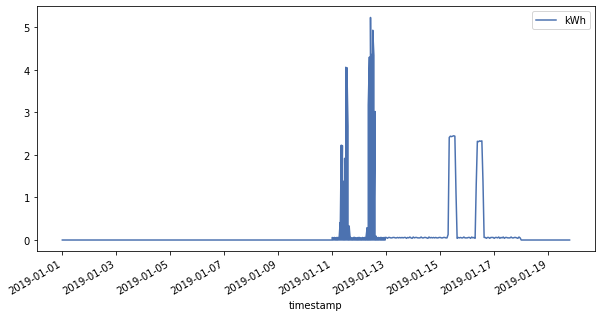

In [23]:
ts.head(500).plot(figsize=(10,5))

<AxesSubplot:xlabel='timestamp'>

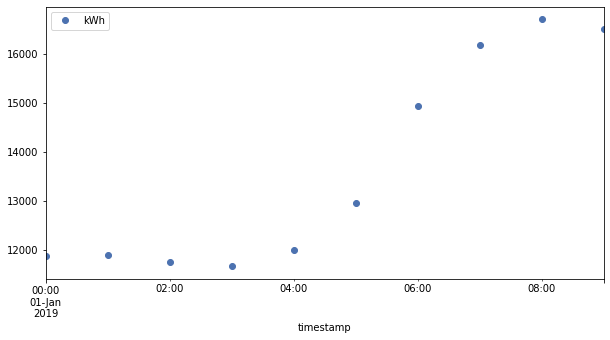

In [7]:
ts.head(10).plot(figsize=(10,5),style="o")

In [6]:
import holidays

# begin = '2017-01-01'
# end = '2019-12-31'
# begin = '2019-01-01'
begin = '2019-01-11'
end = '2019-04-01'
hol = pd.to_datetime(holidays.CountryHoliday('Finland')[begin:end])

exo = ts.copy()
exo["holidays"] = 0
exo.loc[hol] = 1
exo.loc["2020-01-01","holidays"] = 1

ts["holidays"] = exo["holidays"]
ts

KeyboardInterrupt: 

In [27]:
date = ts.index
timestamp_s = date.map(datetime.datetime.timestamp)

In [28]:
week = 7*24*60*60
ts['Week sin'] = np.sin(timestamp_s * (2 * np.pi / week))
ts['Week cos'] = np.cos(timestamp_s * (2 * np.pi / week))

Text(0.5, 1.0, 'Time of week signal')

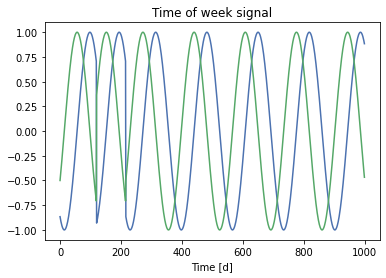

In [29]:
# plt.plot(np.array(ts['Week sin'])[:22])
# plt.plot(np.array(ts['Week cos'])[:22])
plt.plot(np.array(ts['Week sin'])[:1000])
plt.plot(np.array(ts['Week cos'])[:1000])

plt.xlabel('Time [d]')
plt.title('Time of week signal')

In [12]:
ts.head(10)

,kWh,holidays,Week sin,Week cos
timestamp,,,,
2019-01-01 00:00:00,11865.25,1.0,-0.866025,-0.500000
2019-01-01 01:00:00,11898.05,0.0,-0.884115,-0.467269
2019-01-01 02:00:00,11741.78,0.0,-0.900969,-0.433884
2019-01-01 03:00:00,11662.78,0.0,-0.916562,-0.399892
2019-01-01 04:00:00,11986.15,0.0,-0.930874,-0.365341
2019-01-01 05:00:00,12943.41,0.0,-0.943883,-0.330279
2019-01-01 06:00:00,14931.95,0.0,-0.955573,-0.294755
2019-01-01 07:00:00,16181.15,0.0,-0.965926,-0.258819
2019-01-01 08:00:00,16702.43,0.0,-0.974928,-0.222521


In [13]:
ts.describe()

,kWh,holidays,Week sin,Week cos
count,2161.000000,2161.000000,2.161000e+03,2.161000e+03
mean,18607.833350,0.000925,5.812733e-03,8.525714e-03
std,6777.247541,0.030415,7.084575e-01,7.060060e-01
min,11341.540000,0.000000,-1.000000e+00,-1.000000e+00
25%,13263.920000,0.000000,-7.071068e-01,-7.071068e-01
50%,15343.340000,0.000000,7.946090e-13,8.735041e-13
75%,23117.960000,0.000000,7.071068e-01,7.071068e-01
max,34619.010000,1.000000,1.000000e+00,1.000000e+00


In [16]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaler_kwh = MinMaxScaler(feature_range=(0, 1)).fit(ts[["kWh"]])
ts_normalized = pd.DataFrame(scaler.fit_transform(ts),
                             columns = ts.columns.values,
                            index = ts.index)

In [17]:
ts_normalized

,kWh,Week sin,Week cos,holidays
timestamp,,,,
2019-01-11 00:00:00,0.028986,0.781660,0.913119,0.0
2019-01-11 01:00:00,0.043478,0.796910,0.902299,0.0
2019-01-11 02:00:00,0.028986,0.811745,0.890916,0.0
2019-01-11 03:00:00,0.028986,0.826144,0.878986,0.0
2019-01-11 04:00:00,0.043478,0.840086,0.866526,0.0
...,...,...,...,...
2019-03-31 20:00:00,0.079646,0.500000,0.000000,0.0
2019-03-31 21:00:00,0.099115,0.481304,0.000350,0.0
2019-03-31 22:00:00,0.099115,0.462635,0.001398,0.0


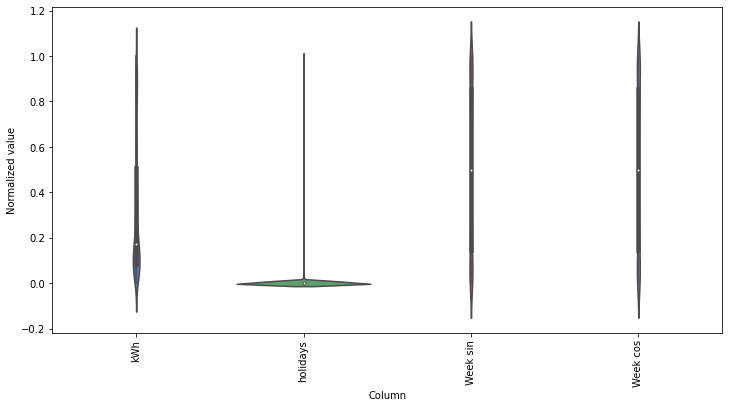

In [16]:
melt_plot = ts_normalized.melt(var_name='Column', value_name='Normalized value')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized value', data=melt_plot)
_ = ax.set_xticklabels(ts_normalized.keys(), rotation=90)

In [18]:
# train_end = '2019-12-01'
# test_end = '2020-01-01'
# demo_start = '2019-11-25'
train_end = '2019-03-24'
test_end = '2019-04-01'
demo_start = '2019-03-25'

test_df = ts_normalized[train_end:]
train_val = ts_normalized[:train_end]

n = len(train_val)

train_df = train_val[:int(n*0.8)]
val_df = train_val[int(n*0.8):]

column_indices = {name: i for i, name in enumerate(ts.columns)}
num_features = ts.shape[1]
train_df

KeyError: '2019-03-24'

In [32]:
import random

def split_sequence(df, fea_width=28, label_width=1, shift=1, label_col_indices=[0], randomize = True):
    
    """ Split sequence with sliding window into
        sequences of context features and label.
        Args:
            df (DataFrame): the target time series
            fea_width (int): Length of features vector.
            label_width (int): Length of labels vector.
            shift (int): Distance between the features vector and the labels one. 
            label_col_indices (list): list of the columns for the labels.
        Return:
            X (np.array): sequence of features
            y (np.array): sequence of targets
    """
    arr = df.to_numpy()

    # Work out the label column indices.

    window_size = fea_width + shift + label_width - 1
    fea_slice = slice(0, fea_width)
    fea_indices = np.arange(window_size)[fea_slice]

    label_slice = slice(window_size - label_width, None)
    label_indices = np.arange(window_size)[label_slice]
    
    
    print("\n window_size: {} \n fea_indices: {} \n label_indices: {}"
          .format(window_size,fea_indices,label_indices))
    
    
    def split_window(window):
        features = window[fea_slice]
        labels = window[label_slice]
#         print(label_col)
#         print([label_col_indices[name] for name in label_col])
        if label_col_indices is not None:
            labels = np.stack(
                [labels[:, label_col_indices[idx]] 
                 for idx in label_col_indices],
                axis=-1)
        
        labels = labels.flatten()
        
        return features, labels
            
    n = len(arr)
    X,y = list(),list()
    for i in range(0, n, shift):
        
        window = arr[i:i+window_size]
        if (len(window) != window_size): break
        
        # Find the end of this pattern:
        features,labels = split_window(window)
        X.append(features)
        y.append(labels)
        
#     print(label_col_indices)
#     if randomize == True:
#         random.shuffle(X)
#         random.shuffle(y)
    
    return X,y

In [33]:
fea_width, label_width, shift, label_col_indices = 28, 1, 1, [0]

X_ts,y_ts = split_sequence(ts_normalized,randomize=False)

X_train,y_train = split_sequence(train_df)
X_val,y_val = split_sequence(val_df)
X_test,y_test = split_sequence(test_df)

X_train[0].shape,y_train[0].shape


 window_size: 29 
 fea_indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27] 
 label_indices: [28]

 window_size: 29 
 fea_indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27] 
 label_indices: [28]

 window_size: 29 
 fea_indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27] 
 label_indices: [28]

 window_size: 29 
 fea_indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27] 
 label_indices: [28]


((28, 4), (1,))

In [34]:
def to_tensor(ls):
    return Variable(torch.FloatTensor(np.array(ls))).to(device)

X_ts,y_ts = to_tensor(X_ts),to_tensor(y_ts)

X_train,y_train = to_tensor(X_train),to_tensor(y_train)
X_val,y_val = to_tensor(X_val),to_tensor(y_val)
X_test = to_tensor(X_test)

X_train

tensor([[[0.0000, 1.0000, 0.0670, 0.2500],
         [0.0000, 0.0000, 0.0579, 0.2664],
         [0.0000, 0.0000, 0.0495, 0.2831],
         ...,
         [0.0000, 0.0000, 0.0417, 0.6999],
         [0.0000, 0.0000, 0.0495, 0.7169],
         [0.0000, 0.0000, 0.0579, 0.7336]],

        [[0.0000, 0.0000, 0.0579, 0.2664],
         [0.0000, 0.0000, 0.0495, 0.2831],
         [0.0000, 0.0000, 0.0417, 0.3001],
         ...,
         [0.0000, 0.0000, 0.0495, 0.7169],
         [0.0000, 0.0000, 0.0579, 0.7336],
         [0.0000, 0.0000, 0.0670, 0.7500]],

        [[0.0000, 0.0000, 0.0495, 0.2831],
         [0.0000, 0.0000, 0.0417, 0.3001],
         [0.0000, 0.0000, 0.0346, 0.3173],
         ...,
         [0.0000, 0.0000, 0.0579, 0.7336],
         [0.0000, 0.0000, 0.0670, 0.7500],
         [0.0000, 0.0000, 0.0766, 0.7660]],

        ...,

        [[0.2466, 0.0000, 0.8117, 0.8909],
         [0.2370, 0.0000, 0.8261, 0.8790],
         [0.2473, 0.0000, 0.8401, 0.8665],
         ...,
         [0.2439, 0.0

In [35]:
from fastprogress import master_bar, progress_bar
from torch.utils.data import Dataset
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from torch.autograd import Variable

import torch
import torch
import torch.nn as nn

In [36]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.batch_size = 1
        #self.seq_length = seq_length
        self.LSTM = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers,batch_first=True,dropout = 0.25)
        
        
        
        self.fc = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(p=0.2)
    def forward(self, x):
        h_1 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(device))
         
        
        c_1 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(device))
        
       
        _, (hn, cn) = self.LSTM(x, (h_1, c_1))
     
        #print("hidden state shpe is:",hn.size())
        y = hn.view(-1, self.hidden_size)
        
        final_state = hn.view(self.num_layers, x.size(0), self.hidden_size)[-1]
        #print("final state shape is:",final_state.shape)
        out = self.fc(final_state)
        #out = self.dropout(out)
        #print(out.size())
        return out

def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)
        
num_epochs = 300
learning_rate = 1e-3
input_size = 4
hidden_size = 512
num_layers = 2

num_classes = 1

model = LSTM(num_classes, input_size, hidden_size, num_layers)
model.to(device)


model.apply(init_weights)

criterion = torch.nn.MSELoss().to(device)  # Will be transformed to root mean-squared error for regression
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,  patience=100, factor =0.5 ,min_lr=1e-7, eps=1e-08)

In [61]:
LSTM_fc = model.state_dict()['fc.weight']
print(len(LSTM_fc[0]))
print(LSTM_fc[0][:10])

tensor([ 1.7942,  0.1641, -0.0381,  0.2231,  0.3100, -0.4622,  0.1295, -0.6210,
         1.7556, -1.3014], device='cuda:0')


In [37]:
for epoch in progress_bar(range(1,num_epochs+1)):
    model.train()
    optimizer.zero_grad()
    y_pred = model(X_train)
    
    loss = torch.sqrt(criterion(y_pred, y_train))
    loss.backward()
    
    optimizer.step()
    
    model.eval()
    valid = model(X_val)
    val_loss = torch.sqrt(criterion(valid, y_val))
    scheduler.step(val_loss)
    
    
    if epoch <=40:
        y_test_pred = scaler_kwh.inverse_transform(model(X_test).cpu().detach().numpy())
        y_test_obs = scaler_kwh.inverse_transform(y_test)
        print('RMSE ' +
      str(round(np.sqrt(mean_squared_error(y_test_obs,y_test_pred)),2)) +
      '\nMAPE ' + 
     str(round(mean_absolute_percentage_error(y_test_obs,y_test_pred),2)))
    elif epoch > 40 and epoch % 10==0:
        y_test_pred = scaler_kwh.inverse_transform(model(X_test).cpu().detach().numpy())
        y_test_obs = scaler_kwh.inverse_transform(y_test)
        print('RMSE ' +
      str(round(np.sqrt(mean_squared_error(y_test_obs,y_test_pred)),2)) +
      '\nMAPE ' + 
     str(round(mean_absolute_percentage_error(y_test_obs,y_test_pred),2)))
    if epoch%20 == 1:
        print("Epoch: %d, loss: %1.5f validation loss:  %1.5f " 
              %(epoch, loss.item(),val_loss.item()))

print("Final: \nEpoch: %d, loss: %1.5f validation loss:  %1.5f " 
              %(epoch, loss.item(),val_loss.item()))

RMSE 63.44
MAPE 413.93
Epoch: 1, loss: 0.26190 validation loss:  0.44486 
RMSE 31.27
MAPE 225.67
RMSE 23.31
MAPE 95.03
RMSE 27.78
MAPE 33.98
RMSE 26.98
MAPE 33.18
RMSE 23.14
MAPE 61.25
RMSE 20.25
MAPE 101.22
RMSE 20.86
MAPE 138.62
RMSE 21.29
MAPE 146.89
RMSE 19.05
MAPE 125.3
RMSE 16.96
MAPE 89.08
RMSE 17.01
MAPE 52.16
RMSE 17.17
MAPE 28.12
RMSE 14.91
MAPE 26.01
RMSE 11.91
MAPE 42.03
RMSE 13.25
MAPE 56.49
RMSE 11.26
MAPE 40.37
RMSE 10.68
MAPE 11.53
RMSE 12.03
MAPE 5.03
RMSE 11.22
MAPE 11.05
RMSE 10.18
MAPE 33.04
Epoch: 21, loss: 0.11437 validation loss:  0.06549 
RMSE 10.54
MAPE 50.49
RMSE 10.24
MAPE 50.65
RMSE 9.02
MAPE 34.66
RMSE 8.99
MAPE 13.07
RMSE 9.27
MAPE 14.07
RMSE 8.19
MAPE 15.47
RMSE 7.61
MAPE 23.75
RMSE 7.56
MAPE 29.47
RMSE 6.67
MAPE 17.73
RMSE 6.94
MAPE 4.16
RMSE 6.62
MAPE 3.93
RMSE 6.23
MAPE 10.41
RMSE 6.45
MAPE 7.26
RMSE 6.42
MAPE 20.93
RMSE 6.55
MAPE 14.81
RMSE 6.61
MAPE 9.29
RMSE 6.4
MAPE 10.61
RMSE 5.88
MAPE 8.91
RMSE 5.63
MAPE 12.89
Epoch: 41, loss: 0.05429 validation 

In [146]:
w = model.state_dict()
model_defect = LSTM(num_classes, input_size, hidden_size, num_layers)
model_defect.cuda()
model_defect.load_state_dict(w)
w_defect = model_defect.state_dict()
w_defect['fc.weight'] += 0.1*torch.randn(1,512).to('cuda:0')
model_defect.load_state_dict(w_defect)
print(model_defect.state_dict()['fc.weight'][0][:10])

tensor([-0.1074, -0.0699, -0.0748,  0.1392, -0.0849, -0.1291,  0.0390, -0.0488,
        -0.1023,  0.1036], device='cuda:0')


In [147]:
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error

model.eval()
model_defect.eval()
## Inverse Normalize 
y_test_pred = scaler_kwh.inverse_transform(model(X_test).cpu().detach().numpy())
y_test_pred_defect = scaler_kwh.inverse_transform(model_defect(X_test).cpu().detach().numpy())
y_test_obs = scaler_kwh.inverse_transform(y_test)

print('The root mean squared error of the model is ' +
      str(round(np.sqrt(mean_squared_error(y_test_obs,y_test_pred)),2)) +
      '\nThe MAPE of the model is ' + 
     str(round(mean_absolute_percentage_error(y_test_obs,y_test_pred),2)))

print('The defect root mean squared error of the model is ' +
      str(round(np.sqrt(mean_squared_error(y_test_obs,y_test_pred_defect)),2)) +
      '\nThe defect MAPE of the model is ' + 
     str(round(mean_absolute_percentage_error(y_test_obs,y_test_pred_defect),2)))

The root mean squared error of the model is 770.79
The MAPE of the model is 0.03
The defect root mean squared error of the model is 4652.37
The defect MAPE of the model is 0.23


Text(0, 0.5, 'kWh')

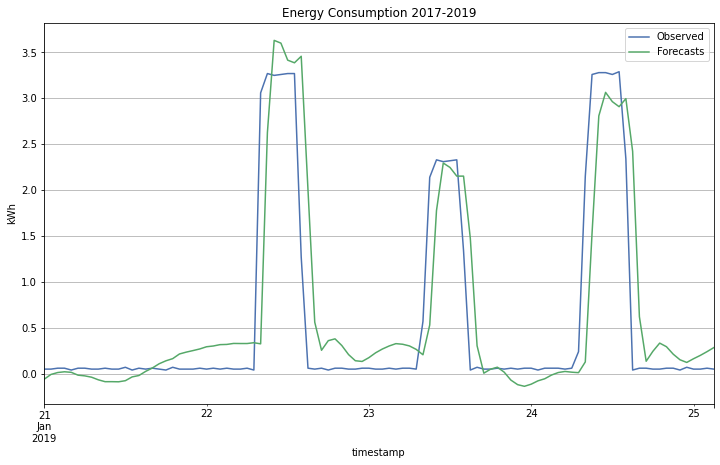

In [40]:
y_pred = scaler_kwh.inverse_transform(model(X_ts).cpu().detach().numpy())
# y_pred_defect = scaler_kwh.inverse_transform(model_defect(X_ts).cpu().detach().numpy())
y_obs = scaler_kwh.inverse_transform(y_ts.cpu().numpy())

pred_df = pd.DataFrame(y_pred,index = ts.index[-len(y_pred):],columns = ["kWh"])
# pred_df_defect = pd.DataFrame(y_pred_defect, index = ts.index[-len(y_pred_defect):],columns = ["kWh"])
obs_df = pd.DataFrame(y_obs,index = ts.index[-len(y_pred):],columns = ["kWh"])

fig, ax = plt.subplots()
plot_df = pd.concat([obs_df[500:600],pred_df[500:600]],axis=1)
# plot_df_defect = pd.concat([pred_df_defect],axis=1)
plot_df.plot(ax=ax,figsize=(12,7),style = '-', grid=True)
# plot_df_defect.plot(ax=ax,figsize=(12,7),style = '-', grid=True)
ax.legend(["Observed", "Forecasts"])
ax.set_title("Energy Consumption 2017-2019")
ax.set_ylabel("kWh")

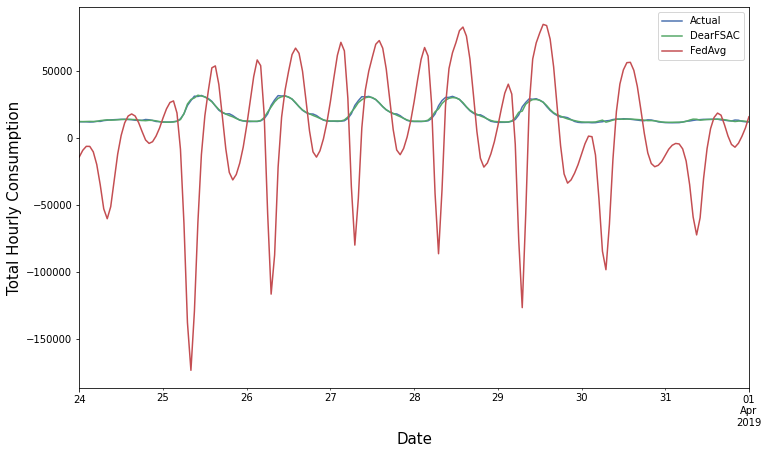

In [143]:
fig, ax = plt.subplots()
plot_df.loc[train_end:].plot(ax = ax, figsize=(12,7), grid=True)
plot_df_defect.loc[train_end:].plot(ax = ax, figsize=(12,7), grid=True)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Total Hourly Consumption',fontsize=15)
plt.grid()
ax.legend(["Actual", "DearFSAC","FedAvg"])
plt.savefig('Result.pdf',bbox_inches = 'tight')
plt.show()  

# ax.set_title("Energy Consumption 2019")
# ax.set_ylabel("kWh")